# Explore here

In [54]:
# Your code here

- **Obtaining data**

**DATA FROM** -> https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv

In [55]:
import os
import pandas as pd
import csv

df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

os.makedirs("../data/raw", exist_ok = True)
file_path = os.path.join("../data/raw", "sales.csv")

df.to_csv(file_path, index=False)

df.head(10)

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
5,2022-09-08 17:10:08.079328,60.081865
6,2022-09-09 17:10:08.079328,68.466704
7,2022-09-10 17:10:08.079328,67.765106
8,2022-09-11 17:10:08.079328,70.512261
9,2022-09-12 17:10:08.079328,74.656453


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


2 columns, 366 rows and no missing data

- To start we will transform the **date** column to a proper DateTime object to be used for time-based operations, then we'll set **date** to be the index

In [57]:
df["date"] = pd.to_datetime(df.date)

In [58]:
df = df.set_index("date")
df.head()

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633


- **ANALYSIS**

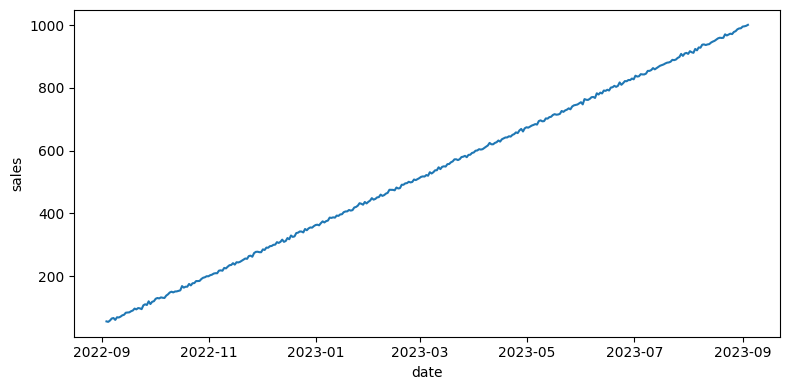

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize=(8, 4))
sns.lineplot(data=df["sales"])

plt.tight_layout()
plt.show()

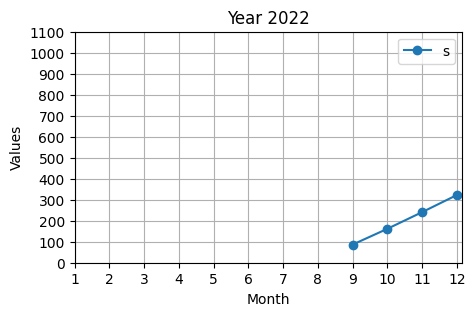

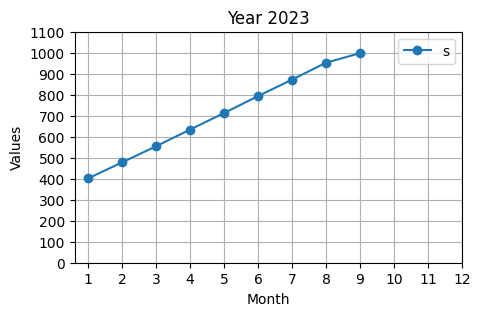

In [60]:
import numpy as np

plot_df = df.copy()
plot_df['Year'] = df.index.year
plot_df['Month'] = df.index.month

for year, group in plot_df.groupby('Year'):
    plt.figure(figsize=(5, 3))
    
    monthly_means = group.groupby('Month')["sales"].mean()
    monthly_means.plot(kind='line', marker='o', ax=plt.gca())

    plt.title(f'Year {year}')
    plt.xlabel('Month')
    plt.ylabel('Values')
    plt.xticks(range(1, 13))
    plt.legend("sales")
    plt.grid(True)

    plt.yticks(np.arange(0, 1200, 100))

    plt.show()

In [61]:
! pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df, period = 12)
decomposition

- **TREND**

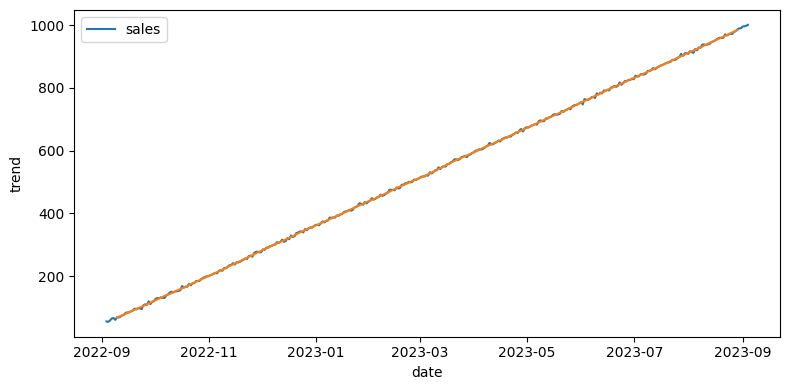

In [63]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = df)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

As previously shown in the sales/date plot, there's a positive trend over the years

- **SEASONALITY**

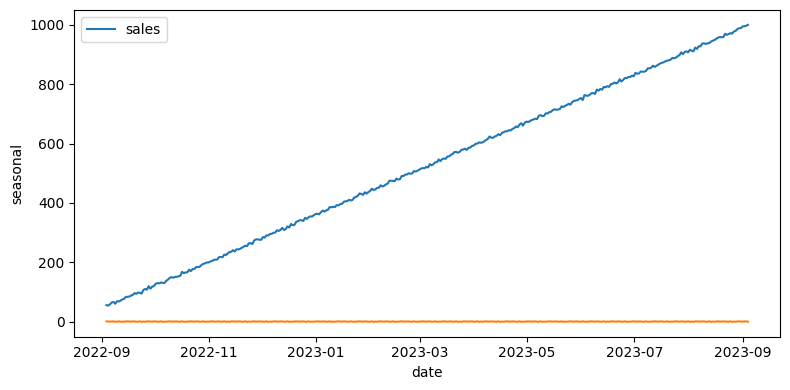

In [64]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = df)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

The seasonality shows a constant pattern, this was expected given the continuous upwards trend

- **Dickey-Fuller test** to test the hypothesis:

    - Null hypothesis -> The series is stationary
    - Alt hypotheis -> The series is mom-stationary

In [65]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Dickey-Fuller test results:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(df)

Dickey-Fuller test results:


Test Statistic                  0.545414
p-value                         0.986190
#Lags Used                     13.000000
Number of Observations Used   352.000000
Critical Value (1%)            -3.449065
Critical Value (5%)            -2.869786
Critical Value (10%)           -2.571163
dtype: float64

p-value -> 0.986190 

Since the p-value > 0.05 we'll take the series as non-stationary

- **ANALYSIS OF VARIABILITY**

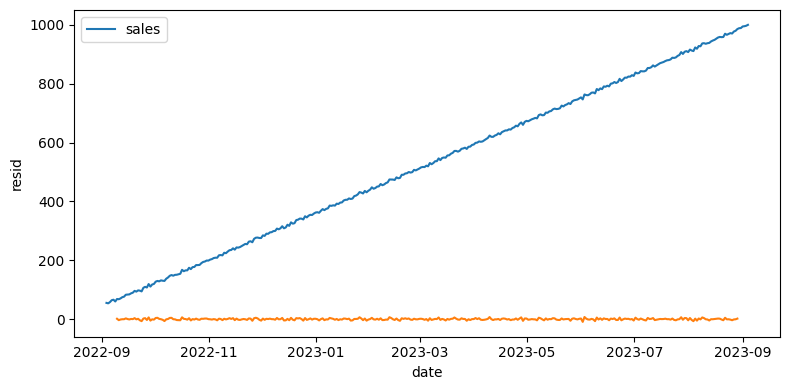

In [66]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = df)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

No significant observations from the variability analysis

- **AUTOCORRELATION ANALYSIS**

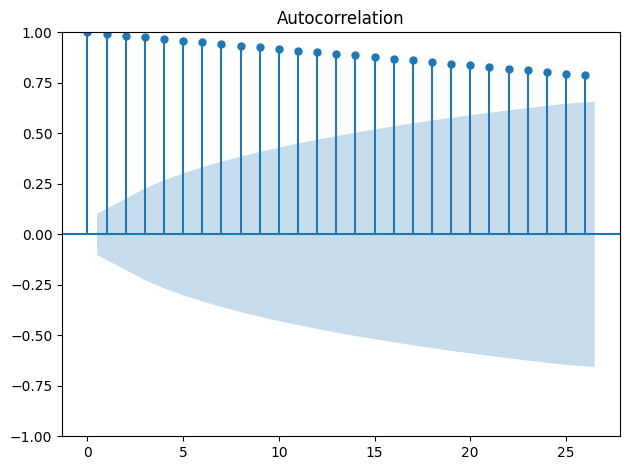

In [67]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df)

plt.tight_layout()

plt.show()

This autocorrelation plot suggests the time series exhibits strong autocorrelation across multiple lags

- **MODEL TRAINING**

In [68]:
pd.options.display.float_format = "{:.6f}".format

In [69]:
df_stationary = df.diff().dropna()

test_stationarity(df_stationary)

Dickey-Fuller test results:


Test Statistic                 -9.430263
p-value                         0.000000
#Lags Used                     12.000000
Number of Observations Used   352.000000
Critical Value (1%)            -3.449065
Critical Value (5%)            -2.869786
Critical Value (10%)           -2.571163
dtype: float64

In [70]:
! pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable


In [71]:
from pmdarima import auto_arima

model = auto_arima(df, seasonal = False, trace = True, m = 12)

Performing stepwise search to minimize aic


/home/vscode/.local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be remove

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.11 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.02 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.21 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.14 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.09 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.880 seconds


In [72]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Thu, 13 Mar 2025   AIC                           1839.552
Time:                        20:45:06   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- **MODEL PREDICTION**

In [73]:
forecast = model.predict(100)
forecast

/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2023-09-04 17:10:08.079328   1002.158148
2023-09-05 17:10:08.079328   1004.831668
2023-09-06 17:10:08.079328   1007.423289
2023-09-07 17:10:08.079328   1010.021630
2023-09-08 17:10:08.079328   1012.619419
                                 ...    
2023-12-08 17:10:08.079328   1249.022047
2023-12-09 17:10:08.079328   1251.619878
2023-12-10 17:10:08.079328   1254.217709
2023-12-11 17:10:08.079328   1256.815540
2023-12-12 17:10:08.079328   1259.413371
Freq: D, Length: 100, dtype: float64

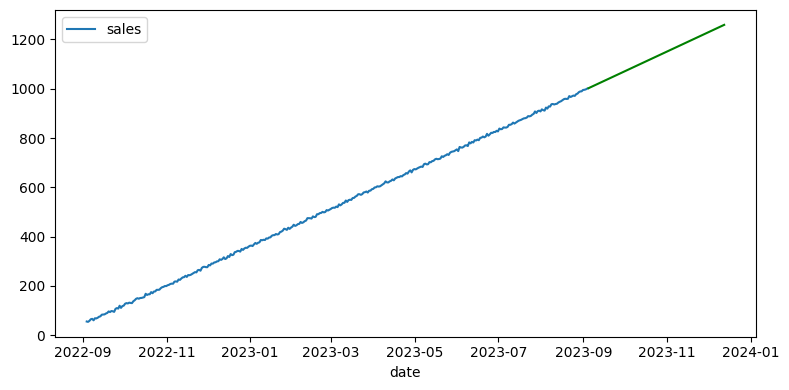

In [74]:
fig, axis = plt.subplots(figsize = (8, 4))

sns.lineplot(data = df)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

Our model predicted the sales will keep increasing in the next 100 months